ThinCurr Python Example: Compute frequency-response in a torus {#doc_tCurr_torus_fr}
==========
In this example we demonstrate how to compute frequency response for a model from both coils and the plasma mode computed in \ref doc_tCurr_torus_mode.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.meshing import write_ThinCurr_mesh, build_torus_bnorm_grid, build_periodic_mesh
from OpenFUSIONToolkit.util import build_XDMF

## Compute frequency response

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. As this is a larger model, we use `nthreads=4` to increase the number of cores used for the calculation. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
tw_coil = ThinCurr(nthreads=4)
tw_coil.setup_model(mesh_file='thincurr_ex-torus.h5',xml_filename='oft_in.xml')
tw_coil.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tCurr_SIMSOPT
Revision id:          3a704f3
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =        3122
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         2394
  # of edges     =         7182
  # of cells     =         4788
  # of holes     =            2
  # of pcoils    =            0
  # of closures  =            1
  # of Icoils    =            1

  Building holes

  Loading region resistivit

### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_thincurr_ex4 for more information).

In [4]:
tw_coil.compute_Lmat()
tw_coil.compute_Rmat()

 Building element<->element self inductance matrix
   Time =    4.2721970000000002     
 Building resistivity matrix


## Compute frequency response from coils
For the first case we will compute the frequency response on the model to current driven in the coil set specified in `oft_in.xml` at 1 kHz. To do this we first compute the coil to model mutual inductance matrix using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_Mcoil "tw_plate.compute_Mcoil()". Then we compute a purely real driver voltage by using the first row of this matrix (equivalent to multiplying by 1). Finally we use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.compute_freq_response "tw_plate.compute_freq_response()" to compute the frequency response to this input.

In [5]:
Mcoil = tw_coil.compute_Mcoil()
driver = np.zeros((2,tw_coil.nelems))
driver[0,:] = Mcoil[0,:]
result = tw_coil.compute_freq_response(driver,freq=1.E3)

 Building coil<->element inductance matrices

 Starting Frequency-response run
   Frequency [Hz] =   1.00000E+03
 Starting GMRES solver
     0  0.000000E+00  1.133720E+04
    60  2.097016E+02  1.077125E+00  5.136466E-03
   120  2.105014E+02  1.787020E-02  8.489348E-05
   180  2.104196E+02  7.443755E-04  3.537576E-06
   240  2.104221E+02  1.549770E-06  7.365053E-09
   300  2.104221E+02  2.206775E-08  1.048737E-10
   360  2.104221E+02  8.126669E-10  3.862079E-12
   Time =    1.1604360000000000     


### Save currents to plot files
The resulting currents are saved for plotting using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.save_current "tw_plate.save_current()". Here we save the real (`Jr`) and Imaginary (`Ji`) components of the response for visualization. Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_plate.build_XDMF()" to generate the [XDMF descriptor files](https://www.xdmf.org/index.php/XDMF_Model_and_Format) for plotting with VisIt of Paraview.

In [6]:
tw_coil.save_current(result[0,:],'Jr_coil')
tw_coil.save_current(result[1,:],'Ji_coil')
build_XDMF(path='.')

Removing old Xdmf files
Creating output files


### Compute sensor mutual inductance matrices
We can also compute the pickup of sensors in response to both the coil and the eddy currents. To do this we compute the mutual coupling matrices between the sensors and model and the sensors and the driver coils (`icoils`). 

In [7]:
Msensor, Msc = tw_coil.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           2
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix
 Building coil<->coil inductance matrix
 Building driver->element inductance matrices


### Print probe signals for frequency response

In [8]:
probe_signals = np.dot(result,Msensor)
probe_signals[1,:] += np.dot(np.r_[1.0],Msc)
for i in range(probe_signals.shape[1]):
    print('Real: {0:13.5E}, Imaginary: {1:13.5E}'.format(*probe_signals[:,i]))

Real:  -4.61307E+00, Imaginary:   8.51432E-01
Real:   4.61249E+00, Imaginary:  -8.51434E-01


## Setup plasma mode driver model


In [9]:
tw_mode = ThinCurr(nthreads=4)
tw_mode.setup_model(mesh_file='thincurr_mode.h5')
with h5py.File('thincurr_mode.h5', 'r+') as h5_file:
    mode_drive = np.asarray(h5_file['thincurr/driver'])


Creating thin-wall model
 Orientation depth =       12640
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         6320
  # of edges     =        18960
  # of cells     =        12640
  # of holes     =            3
  # of pcoils    =            0
  # of closures  =            2
  # of Icoils    =            0

  Building holes


[    0] WARNING : Unable to find "thincurr" XML node
[    0] WARNING : No "thincurr" XML node, using "eta=mu0" for all regions


## Compute coupling from plasma mode to torus model

In [10]:
mode_driver = tw_mode.cross_eval(tw_coil,mode_drive)

 Applying MF element<->element inductance matrix
   Time =    25.194537000000000     


## Compute frequency-response to plasma modes

In [11]:
result = tw_coil.compute_freq_response(mode_driver,freq=1.E3)


 Starting Frequency-response run
   Frequency [Hz] =   1.00000E+03
 Starting GMRES solver
     0  0.000000E+00  2.127798E+05
    60  1.587760E+03  1.293884E+01  8.149120E-03
   120  1.593300E+03  6.824232E-02  4.283079E-05
   180  1.593040E+03  2.798517E-03  1.756715E-06
   240  1.593045E+03  4.038827E-05  2.535287E-08
   300  1.593045E+03  1.207228E-06  7.578114E-10
   360  1.593045E+03  7.989498E-09  5.015237E-12
   Time =    1.1537470000000001     


## Compute sensor mutual inductance matrices

In [12]:
tw_coil.save_current(result[0,:],'Jr_mode')
tw_coil.save_current(result[1,:],'Ji_mode')
tw_coil.build_XDMF()

Removing old Xdmf files
Creating output files


In [13]:
Msensor_plasma, _ = tw_mode.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           2
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix
 Building coil<->coil inductance matrix


## Print probe signals for frequency response

In [14]:
probe_signals = np.dot(result,Msensor) + np.dot(mode_drive,Msensor_plasma)
for i in range(probe_signals.shape[1]):
    print('Real: {0:13.5E}, Imaginary: {1:13.5E}'.format(*probe_signals[:,i]))

Real:   2.51255E-03, Imaginary:   6.17204E-03
Real:  -1.57341E-03, Imaginary:  -9.69947E-03


# Plot current fields

## Load data from plot files

In [15]:
with h5py.File('mesh.0001.h5','r') as h5_file:
    r = np.asarray(h5_file['R_surf'])
    lc = np.asarray(h5_file['LC_surf'])
with h5py.File('vector_dump.0001.h5','r') as h5_file:
    Ji = np.asarray(h5_file['Ji_mode_v0000'])

## Create pyvista mesh for plotting

In [16]:
celltypes = np.array([pyvista.CellType.TRIANGLE for _ in range(lc.shape[0])], dtype=np.int8)
cells = np.insert(lc, [0,], 3, axis=1)
grid = pyvista.UnstructuredGrid(cells, celltypes, r)
grid["vectors"] = Ji
grid.set_active_vectors("vectors")

## Plot current vectors on surface

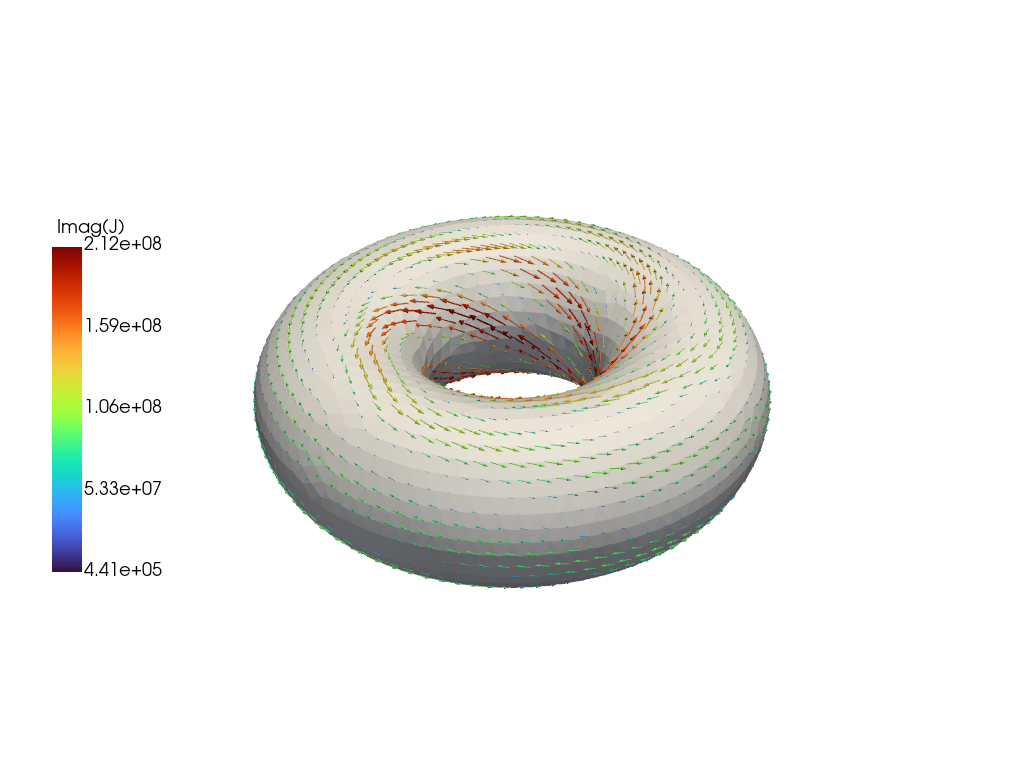

In [17]:
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(Ji,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.05})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show(jupyter_backend='static')